In [7]:
%pip install pandas geopandas matplotlib shapely pgeocode

Note: you may need to restart the kernel to use updated packages.


In [1]:
#%pip install pgeocode

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import pgeocode



Merged 2288 ZIPs with coordinates.


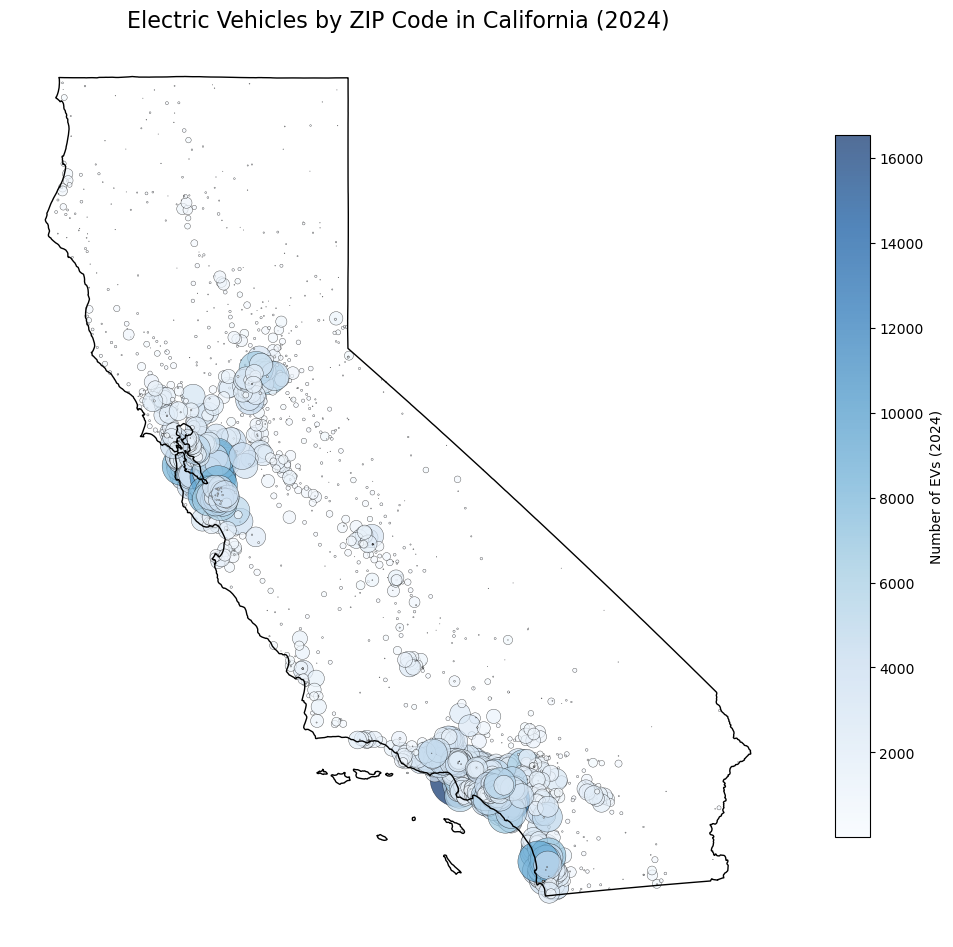

In [6]:


# ----------------------------------------------------------
# 1. Load your EV data
# ----------------------------------------------------------
ev_path = "Data/EV_Pop_Growth_23_24.csv"   # adjust if needed
ev_df = pd.read_csv(ev_path)

# Clean ZIP formatting: keep digits, pad to 5 chars
ev_df["Zip Code"] = (
    ev_df["Zip Code"]
    .astype(str)
    .str.extract(r"(\d+)", expand=False)
    .str.zfill(5)
)

# Clean 2024 values
ev_df = ev_df.dropna(subset=["Zip Code", "2024"])
ev_df["2024"] = pd.to_numeric(ev_df["2024"], errors="coerce")
ev_df = ev_df.dropna(subset=["2024"])

# ----------------------------------------------------------
# 2. Get lat/lon for those ZIPs using pgeocode (offline data)
# ----------------------------------------------------------
unique_zips = ev_df["Zip Code"].unique().tolist()

nomi = pgeocode.Nominatim("us")
zip_loc = nomi.query_postal_code(unique_zips)

# Keep only California ZIPs with valid coordinates
zip_loc = zip_loc[
    (zip_loc["state_code"] == "CA") &
    zip_loc["latitude"].notna() &
    zip_loc["longitude"].notna()
][["postal_code", "latitude", "longitude"]]

# Merge ZIP locations back into EV data
merged_df = ev_df.merge(
    zip_loc,
    left_on="Zip Code",
    right_on="postal_code",
    how="inner"
)

if merged_df.empty:
    raise ValueError("No matching CA ZIP codes with coordinates were found.")

print(f"Merged {len(merged_df)} ZIPs with coordinates.")

# ----------------------------------------------------------
# 3. Convert to GeoDataFrame
# ----------------------------------------------------------
geometry = [
    Point(xy) for xy in zip(merged_df["longitude"], merged_df["latitude"])
]
ev_gdf = gpd.GeoDataFrame(
    merged_df,
    geometry=geometry,
    crs="EPSG:4326"  # lat/lon
)

# ----------------------------------------------------------
# 4. Load California boundary
# ----------------------------------------------------------
states_url = "https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_5m.zip"
states = gpd.read_file(states_url)
ca_state = states[states["STUSPS"] == "CA"].to_crs("EPSG:3857")

# Reproject EV points to match map CRS
ev_gdf = ev_gdf.to_crs("EPSG:3857")

# ----------------------------------------------------------
# 5. Plot EVs by ZIP on California map
# ----------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 12))

# California outline
ca_state.boundary.plot(ax=ax, linewidth=1, color="black")

# Marker size & color scaled by 2024 EV count
ev_values = ev_gdf["2024"]
size_scale = 0.1  # tweak this if circles are too big/small
sizes = ev_values * size_scale

scatter = ax.scatter(
    ev_gdf.geometry.x,
    ev_gdf.geometry.y,
    s=sizes,
    c=ev_values,
    cmap="Blues",
    alpha=0.7,
    edgecolor="k",
    linewidth=0.3
)

# Colorbar
cbar = plt.colorbar(scatter, ax=ax, shrink=0.6)
cbar.set_label("Number of EVs (2024)")

# Title & formatting
ax.set_title("Electric Vehicles by ZIP Code in California (2024)", fontsize=16)
ax.set_axis_off()
ax.set_aspect("equal", "box")

plt.tight_layout()
plt.show()


/srv/conda/lib/python3.11/site-packages/matplotlib/collections.py:999: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/srv/conda/lib/python3.11/site-packages/matplotlib/collections.py:999: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


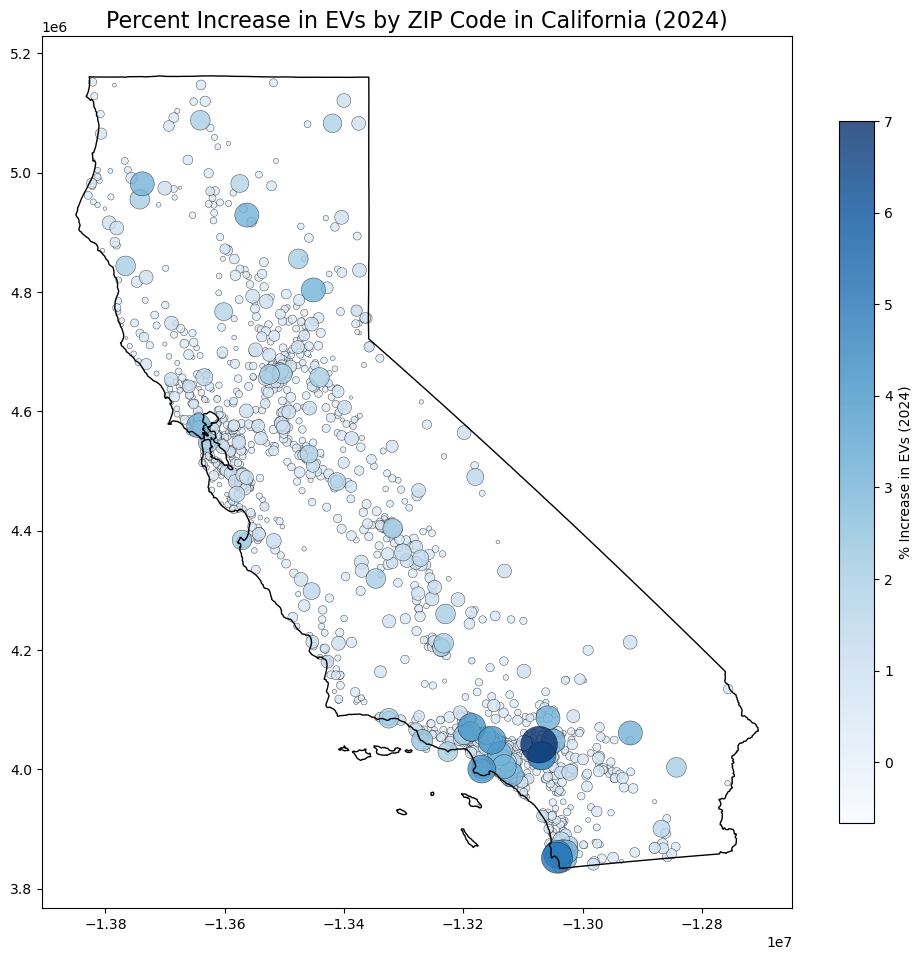

In [43]:
# --- Map of % change by ZIP ---
ev_gdf = ev_gdf.sort_values("%change")
plot_gdf = ev_gdf.drop(ev_gdf["%change"].idxmax())
value_col = "%change"   # update if your column name is different
ev_change = plot_gdf[value_col]

fig, ax = plt.subplots(figsize=(10, 12))

# Base: California outline
ca_state.boundary.plot(ax=ax, linewidth=1, color="black")

# Points: use 2024 or %change (pick one)
values = plot_gdf["%change"]         # or ev_gdf["%change"]
sizes = values * 100      # make them big enough

scatter = ax.scatter(
    plot_gdf.geometry.x,
    plot_gdf.geometry.y,
    s=sizes,
    c=values,
    cmap="Blues",
    alpha=0.8,
    edgecolor="k",
    linewidth=0.3
)

cbar = plt.colorbar(scatter, ax=ax, shrink=0.6)
cbar.set_label("% Increase in EVs (2024)")

ax.set_title("Percent Increase in EVs by ZIP Code in California (2024)", fontsize=16)
ax.set_aspect("equal", "box")
# DO NOT call ax.set_axis_off() for now

plt.tight_layout()

# 🔹 Save with a NEW name so we know it's fresh
fig.savefig("Perc_Change.png", dpi=300, bbox_inches="tight")
fig.savefig("Perc_Change.pdf", bbox_inches="tight")

plt.show()

/srv/conda/lib/python3.11/site-packages/matplotlib/collections.py:999: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/srv/conda/lib/python3.11/site-packages/matplotlib/collections.py:999: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


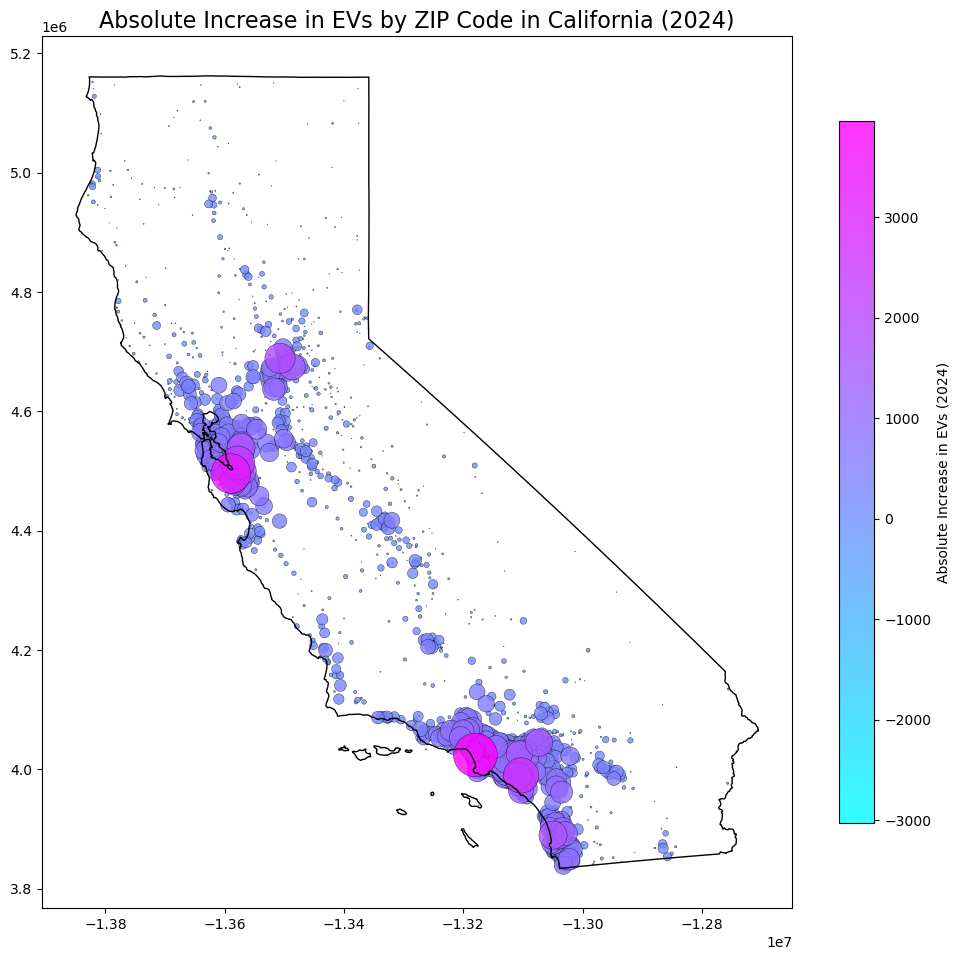

In [36]:
# --- Map of % change by ZIP ---

value_col = "YoY Change"   # update if your column name is different
ev_change = ev_gdf[value_col]
ev_gdf = ev_gdf.sort_values("YoY Change")

fig, ax = plt.subplots(figsize=(10, 12))

# Base: California outline
ca_state.boundary.plot(ax=ax, linewidth=1, color="black")

# Points: use 2024 or %change (pick one)
values = ev_gdf["YoY Change"]         # or ev_gdf["%change"]
sizes = values * 0.25      # make them big enough

scatter = ax.scatter(
    ev_gdf.geometry.x,
    ev_gdf.geometry.y,
    s=sizes,
    c=values,
    cmap="cool",
    alpha=0.8,
    edgecolor="k",
    linewidth=0.3
)

cbar = plt.colorbar(scatter, ax=ax, shrink=0.6)
cbar.set_label("Absolute Increase in EVs (2024)")

ax.set_title("Absolute Increase in EVs by ZIP Code in California (2024)", fontsize=16)
ax.set_aspect("equal", "box")
# DO NOT call ax.set_axis_off() for now

plt.tight_layout()

# 🔹 Save with a NEW name so we know it's fresh
fig.savefig("YoY_Change.png", dpi=300, bbox_inches="tight")
fig.savefig("YoY_Change.pdf", bbox_inches="tight")

plt.show()


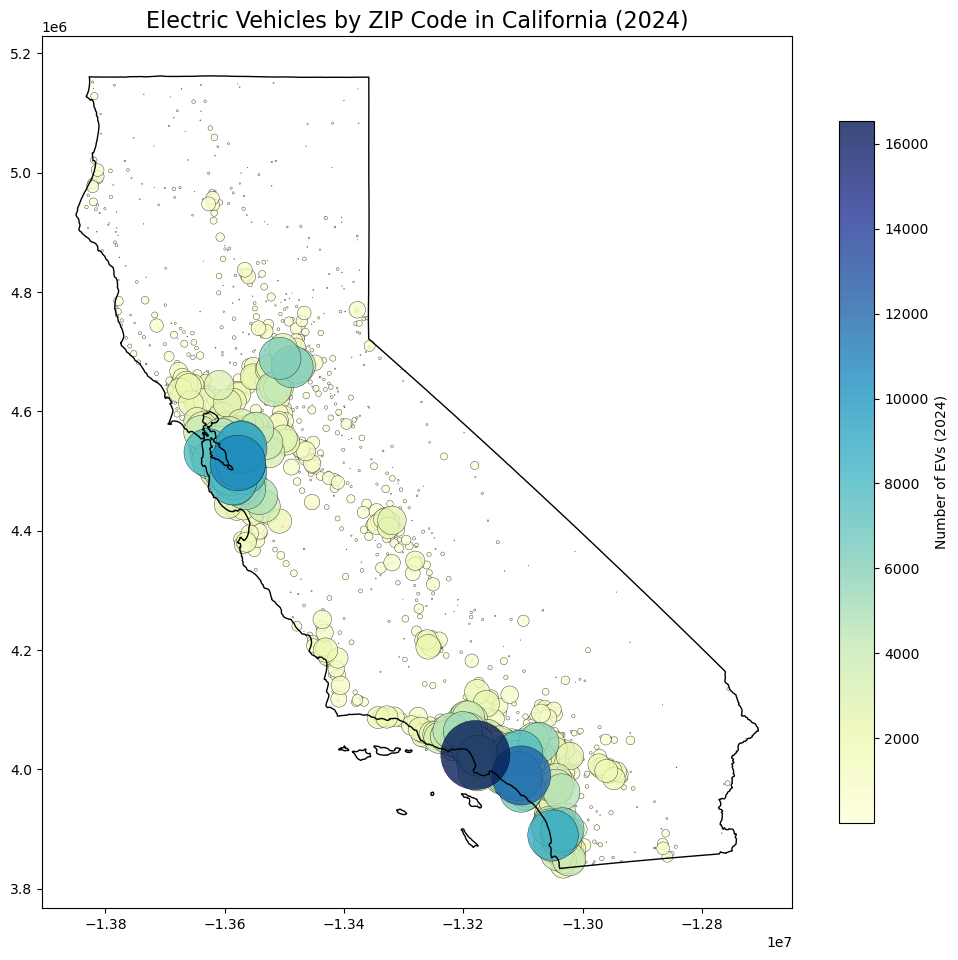

In [44]:
#USE THIS ONE. IT SAVES THE FILE CORRECTLY AND REORDERS THE DATA TO SHOW THE BIGGEST CHANGES FIRST


import matplotlib.pyplot as plt

# REUSE your existing objects:
# - ca_state  (GeoDataFrame of California)
# - ev_gdf    (GeoDataFrame of EV points, already in EPSG:3857)
ev_gdf = ev_gdf.sort_values("2024")

fig, ax = plt.subplots(figsize=(10, 12))

# Base: California outline
ca_state.boundary.plot(ax=ax, linewidth=1, color="black")

# Points: use 2024 or %change (pick one)
values = ev_gdf["2024"]         # or ev_gdf["%change"]
sizes = values * 0.15      # make them big enough

scatter = ax.scatter(
    ev_gdf.geometry.x,
    ev_gdf.geometry.y,
    s=sizes,
    c=values,
    cmap="YlGnBu",
    alpha=0.8,
    edgecolor="k",
    linewidth=0.3
)

cbar = plt.colorbar(scatter, ax=ax, shrink=0.6)
cbar.set_label("Number of EVs (2024)")

ax.set_title("Electric Vehicles by ZIP Code in California (2024)", fontsize=16)
ax.set_aspect("equal", "box")
# DO NOT call ax.set_axis_off() for now

plt.tight_layout()

# 🔹 Save with a NEW name so we know it's fresh
fig.savefig("ev_map_v2.png", dpi=300, bbox_inches="tight")
fig.savefig("ev_map_v2.pdf", bbox_inches="tight")

plt.show()


df_ca is empty – no CA ZIPs with lat/long and EV data. Can't plot.
